# Training WL Cycle

Cells should learn the Wood-Ljungdahl cycle and use it to create X (target molecule) from CO2 and E (energy).
Generally this should be done by letting cells first grow on a complex medium with X, and then slowly changing to a minimal
medium without X, in which they have to generate X by using CO2 and E.
Replication likelihood increases with intracellular X, and cell death likelihood decreases with increasing intracellular E.
So, increasing X by using E and retaining E have to been somewhat in balance.

In earlier runs I tried to do this in one step by generating genomes that have all the required proteins and then let cells grow
on a complex medium that slowly changes towards a minimal medium.
However, cells always died off immediately shortly after the start.
My hypothesis is that these cells were too unstable.
While they have all the required proteins, the kinetics of all proteins are not yet fine-tuned.
So, pathways could move in the wrong direction, stall at some place, or branch out into another direction.
One could assume that changing medium very slowly might give cells enough time to adjust.
But then, the problem is that they rather just drop all proteins and only live on imported X.

So, later my strategy became something closer to real-life, where one would add proteins in multiple stages.
I divided the WL cycle into 6 stages, basically rolling it up from the end.
In each stage some genes are added.
At the same time a molecule species is removed from the medium, so that the cells have to make use of the newly aquired genes.
Each stage first has an _adaption_ phase with rather high mutation rates, where some strategy is used to change the medium.
After that comes a _final_ phase with low mutation rates in minimal medium.
All stages are defined in [chemistry.py](./chemistry.py).
The first 3 stages are:

1. - Add protein with catalytic domain $\text{acetyl-CoA} \rightleftharpoons \text{HS-CoA} + 5 X$
   - Add transporter proteins with domains for acetyl-CoA, E, X
   - Remove X from medium
2. - Add protein with catalytic domain $\text{methyl-FH4} + \text{CO} + \text{HS-CoA} \rightleftharpoons \text{acetyl-CoA} + \text{FH4}$
   - Add transporter proteins with domains for HS-CoA, methyl-FH4
   - Remove acetyl-CoA from medium
3. - Add protein with catalytic domain $\text{NADP} + E \rightleftharpoons \text{NADPH}$
   - Add protein with catalytic domain $\text{CO2} + \text{NADPH} \rightleftharpoons \text{CO} + \text{NADP}$
   - Add transporter protein with domain for NADP
   - Remove CO from medium

The first 2 stages should be straight forward.
There is no drawback for the cell for adapting this part of the metabolic path.
In stage 3 however there is a tradeoff.
E is being used when generating the new intermediate CO.
So here the cell risks a higher likelihood of dying while increasing its likelihood of replicating.
Indeed this is where most runs failed so far.
Some runs advanced to stage 4 or 5 but their cells never got back to a healthy growth rate.
So, I think even in these successful runs, at step 3 something fundamentally wrong happened inside the cells.
Here, I am trying to figure out how I could improve the success rate at stage 3.

In [1]:
import json
from pathlib import Path
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import magicsoup as ms
import e1_co2_fixing.util as util

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
SAVED_RUNS_DIR = Path(".") / "saved_runs"

In [2]:
def load_hparams(runs_glob: str) -> pd.DataFrame:
    records = []
    for hparams_file in SAVED_RUNS_DIR.glob(f"{runs_glob}/hparams.json"):
        run_dir = hparams_file.parent
        with open(hparams_file) as fh:
            hparams = json.load(fh)
        name = run_dir.name
        run = "_".join(name.split("_")[:-1])
        trial = name.split("_")[-1]
        records.append({**hparams, "run": run, "trial": trial, "name": name})

    return pd.DataFrame.from_records(records)

def load_scalars(runs_glob: str, scalars: list[tuple[str, str]]) -> pd.DataFrame:
    records = []
    for event_file in SAVED_RUNS_DIR.glob(f"{runs_glob}/*.out.tfevents.*"):
        for tag, scalar in scalars:
            name = event_file.parent.name
            tf_ea = event_accumulator.EventAccumulator(str(event_file))
            tf_ea.Reload()
            for obj in tf_ea.Scalars(tag):
                records.append(
                    {
                        "name": name,
                        "scalar": scalar,
                        "value": obj.value,
                        "step": obj.step,
                    }
                )
    return pd.DataFrame.from_records(records)

def find_diffs(df: pd.DataFrame, name="name", step="step", val="value") -> pd.DataFrame:
    records = []
    for _, df in df.groupby(name):
        s = df[val].diff(periods=1)
        records.extend(df.loc[s > 0.0, [step, val, name]].to_dict("records"))
    return pd.DataFrame.from_records(records)

def get_proteome_doms(cell: ms.Cell) -> list[list[str]]:
    proteome_strs = []
    for protein in cell.proteome:
        domstrs = []
        for dom in protein.domains:
            if isinstance(dom, ms.TransporterDomain):
                domstrs.append(f"{dom.molecule} [trnsp]")
            if isinstance(dom, ms.CatalyticDomain):
                subs = " + ".join(sorted(d.name for d in dom.substrates))
                prods = " + ".join(sorted(d.name for d in dom.products))
                domstrs.append(" <-> ".join(sorted([subs, prods])))
            if isinstance(dom, ms.RegulatoryDomain):
                domstrs.append(f"{dom.effector} [reg]")
        proteome_strs.append(domstrs)
    return proteome_strs

def get_existing_domains(world: ms.World, runs_label: str, run_names: list[str], steps: list[int]) -> pd.DataFrame:
    records = []
    for run_name in run_names:
        for step in steps:
            world.load_state(statedir=SAVED_RUNS_DIR / runs_label / run_name / f"step={step}")
            print(f"{run_name}: {world.n_cells:,} cells at step {step:,}")
            
            proteomes = [get_proteome_doms(world.get_cell(by_idx=d)) for d in range(world.n_cells)]

            cell_doms: list[set[str]] = []
            for prots in proteomes:
                cell_doms.append(set(d for p in prots for d in p))

            udoms = sorted(list(set(d for doms in cell_doms for d in doms)))

            for cell_i, doms in enumerate(cell_doms):
                for udom in udoms:
                    records.append({
                        "run": run_name,
                        "step": step,
                        "dom": udom,
                        "exists": udom in doms,
                        "cell": cell_i
                    })

    df = pd.DataFrame.from_records(records)
    df["type"] = "catal"
    df.loc[df["dom"].str.endswith("[trnsp]"), "type"] = "trnsp"
    df.loc[df["dom"].str.endswith("[reg]"), "type"] = "reg"
    return df

def get_molecules_df(world: ms.World, runs_label: str, run_names: list[str]) -> pd.DataFrame:
    mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

    records = []
    for run_name in run_names:
        steps = util.find_steps(rundir=SAVED_RUNS_DIR / runs_label / run_name)
        for step in steps:
            world.load_state(statedir=SAVED_RUNS_DIR / runs_label / run_name / f"step={step}", ignore_cell_params=True)
            for mol in world.chemistry.molecules:
                mol_i = mol_2_idx[mol.name]
                xe = world.molecule_map[mol_i].mean().item()
                xi = world.cell_molecules[:, mol_i].mean().item()
                record = {
                    "name": run_name,
                    "step": step,
                    "mol": mol.name,
                }
                records.append({**record, "x": xi, "loc": "int"})
                records.append({**record, "x": xe, "loc": "ext"})
    return pd.DataFrame.from_records(records)

## Linear-50

Here, in each stage, the to-be-removed molecules were removed from the medium linearly over 50 generations.
So during each passage the new medium was prepared with a concentration of the to-be-removed based on the cells' current average generation.
The linear descent was started after the first batch. So for the first batch they would still grow in full complex medium.
In the adaption phase medium was changed as described above over the course of 50 generation at high mutation rates.
Then, in the final phase cells grew for 50 more generations in minimal medium at low mutation rates.

Cells started from random genomes of size 1000 with genes added in inserts of size 200.
Always 2 trials were done for each run.
The final genomes of each successful trial of one stage was used as initial genomes for the next stage.
So, if all trials were successful there would be 2 trials for WL-0, 4 for WL-1, 8 for WL-2.
At WL-2 trials started failing and I aborted to take a look at them.

In [61]:
runs_label = "linear-50"
scalars = [
    ("Cells/Total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Progress", "progress"),
]

scalars_df = load_scalars(f"{runs_label}/*", scalars)
hparams_df = load_hparams(f"{runs_label}/*")
hparams_df.rename(columns={"pathway_label": "stage", "init_label": "init_genome"}, inplace=True)
hparams_df[["name", "stage", "init_genome"]].sort_values("name")

,name,stage,init_genome
2,2023-05-12_18-29_0,WL-0,random
0,2023-05-12_18-29_1,WL-0,random
4,2023-05-12_19-40_0,WL-1,2023-05-12_18-29_0:-1
1,2023-05-12_19-40_1,WL-1,2023-05-12_18-29_0:-1
5,2023-05-12_21-17_0,WL-1,2023-05-12_18-29_1:-1
8,2023-05-12_21-17_1,WL-1,2023-05-12_18-29_1:-1
6,2023-05-13_09-18_0,WL-2,2023-05-12_19-40_0:-1
7,2023-05-13_15-18_0,WL-2,2023-05-12_19-40_0:-1
3,2023-05-13_16-25_0,WL-2,2023-05-12_19-40_1:-1


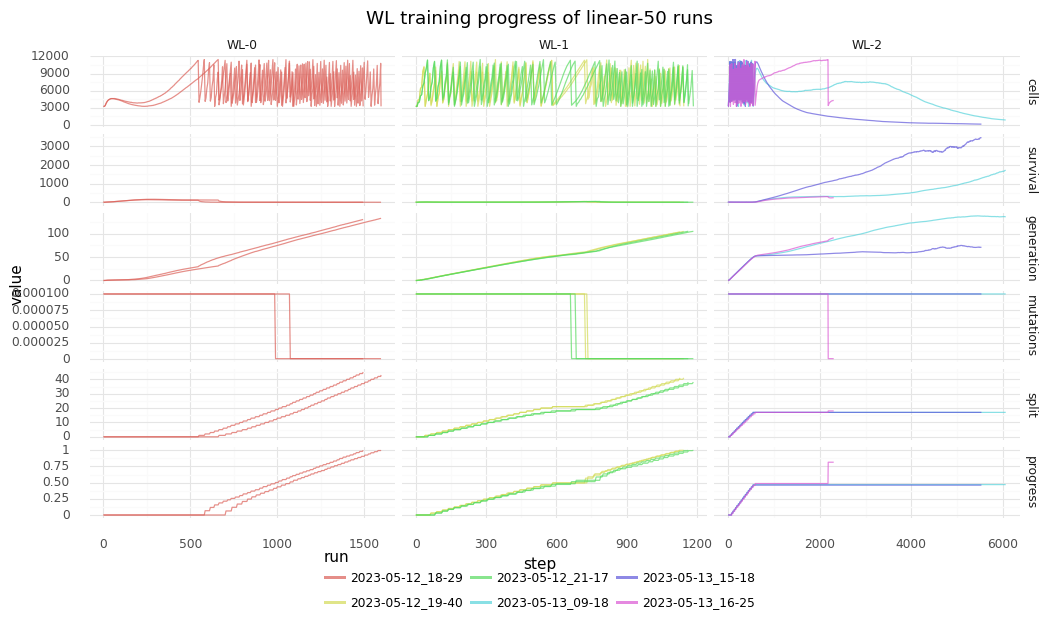

<ggplot: (8778914894023)>

In [62]:
scalars = ["cells", "survival", "generation", "mutations", "split", "progress"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "stage"]], on="name")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ stage", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle(f"WL training progress of {runs_label} runs"))

The first 2 stages look fine. Even in stage WL-2 for the first 250 steps or so it looks like cells are doing well.
They grow at a healthy growth rate.
Then, however growth rate slows down and they slowly start dying.
This seems to happen more or less around the 50% progress mark, where CO is almost fully removed from the medium.
My hypothesis is that they still use the metabolic path from WL-1 and never adapt to the new environment.

In [63]:
world = ms.World.from_file(rundir=SAVED_RUNS_DIR / runs_label, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [65]:
run_names = ["2023-05-13_09-18_0", "2023-05-13_15-18_0", "2023-05-13_16-25_0"]
steps = [0, 250, 500, 750]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-13_09-18_0: 3,276 cells at step 0
2023-05-13_09-18_0: 9,921 cells at step 250
2023-05-13_09-18_0: 8,385 cells at step 500
2023-05-13_09-18_0: 8,177 cells at step 750
2023-05-13_15-18_0: 3,276 cells at step 0
2023-05-13_15-18_0: 10,999 cells at step 250
2023-05-13_15-18_0: 11,032 cells at step 500
2023-05-13_15-18_0: 8,923 cells at step 750
2023-05-13_16-25_0: 3,276 cells at step 0
2023-05-13_16-25_0: 3,890 cells at step 250
2023-05-13_16-25_0: 9,531 cells at step 500
2023-05-13_16-25_0: 8,194 cells at step 750


In [66]:
df = proteomes_df.loc[proteomes_df["step"] == 0]
grp = df.groupby("dom")["exists"]
df = (grp.sum() / grp.count()).reset_index()
df[df["exists"] > 0.8]

,dom,exists
15,CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA,0.999084
16,CO + NADP <-> CO2 + NADPH,0.862943
28,E + NADP <-> NADPH,0.867521
30,E [trnsp],0.997761
43,HS-CoA + X + X + X + X + X <-> acetyl-CoA,0.998982
49,HS-CoA [trnsp],0.997049
58,NADP [trnsp],0.864571
107,methyl-FH4 [trnsp],0.997660


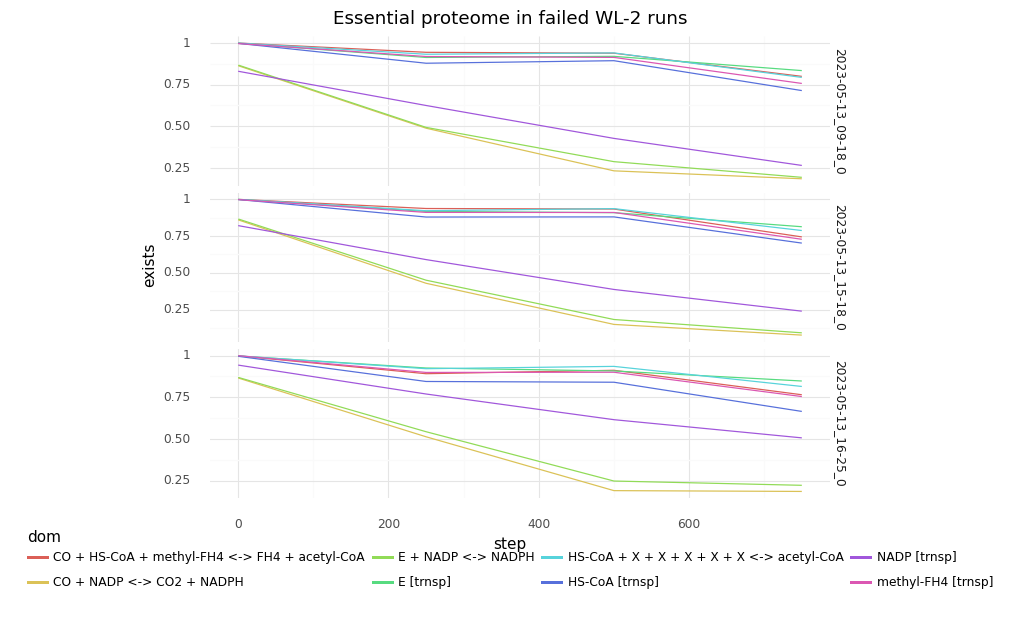

<ggplot: (8778914175409)>

In [67]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'methyl-FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 6), legend_position="bottom")
    + ggtitle("Essential proteome in failed WL-2 runs"))

In colors are the domains that are needed in stage WL-2.
On the y axis is the proportion of cells that have at least one protein with this domain.
At the beginning of both trials, all essential domains exist in more than 80% of cells.
So, the previous stages were indeed successful.
Additionally, it seems that cells get rid of useless proteins quite quickly.
Most of them already dropped the acetyl-CoA transporter that was necessary in WL-0.

In all runs cells quickly removed the 2 catalytic domains of WL-2 and then a little later the NADP transporter.
But they mostly kept all the other domains.
I think in the beginning of the training phase, when CO is still high, they have no reason to adapt the new part of the pathway.
As long as there is still enough CO in the medium, the new genes will actually be a disatvantage for them.
The new genes dicrease E concentrations and thereby give the chance a higher chance to die.
So, cells that got rid of the new genes early on will outgrow the cells that kept the new genes.

## Linear-10

One obvious idea to **linear-50** was to just change medium quicker.
I did the same experiment again but changing medium over the course of only 10 generations.
So ,there is an adaption phase of 10 generations at high mutation rates and a final phase of 10 generations at low mutation rates.

Cells started from random genomes of size 500 with genes added in inserts of size 200.
These genomes are a bit smaller than before.
2 trials were done for each run.
The final genomes of each successful trial of one stage was used as initial genomes for the next stage.
So, if all trials were successful there would be 2 trials for WL-0, 4 for WL-1, 8 for WL-2.

These trials got further than any other run.
They reached the 4th stage WL-3.
In WL-3 these things are done:

3. - Add proteins with a catalytic domain for $\text{formyl-FH4} + \text{NADPH} \rightleftharpoons \text{methylen-FH4} + \text{NADP}$
   - Add proteins with a catalytic domain for $\text{methylen-FH4} + \text{NADPH} \rightleftharpoons \text{methyl-FH4} + \text{NADP}$
   - Add transporter proteins for formyl-FH4
   - Remove methyl-FH4 from medium

This is probably the hardest step since 2 more catalyic domains are added, that both spend energy.
But I was thinking that the only thing that cells have to fine-tune is $\text{NADP} + E \rightleftharpoons \text{NADPH}$.
This reaction shouldn't be too sensitive, so that a decent amount of E is left in the cell.
Then, new NADPH-dependent reactions shouldn't offset the cells' E-levels too much.
But this time, trials started failing at around 50% progress in WL-3.
After a few trials that failed all in the same manner I aborted to take a look at them.

In [4]:
runs_label = "linear-10"
scalars = [
    ("Cells/Total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Progress", "progress"),
]

scalars_df = load_scalars(f"{runs_label}/*", scalars)
hparams_df = load_hparams(f"{runs_label}/*")
hparams_df.rename(columns={"pathway_label": "stage", "init_label": "init_genome"}, inplace=True)
hparams_df[["name", "stage", "init_genome"]].sort_values("name")

,name,stage,init_genome
17,2023-05-14_09-05_0,WL-0,random
5,2023-05-14_09-05_1,WL-0,random
1,2023-05-14_09-39_0,WL-1,2023-05-14_09-05_0:-1
6,2023-05-14_09-39_1,WL-1,2023-05-14_09-05_0:-1
10,2023-05-14_10-02_0,WL-1,2023-05-14_09-05_1:-1
14,2023-05-14_10-02_1,WL-1,2023-05-14_09-05_1:-1
3,2023-05-14_10-21_0,WL-2,2023-05-14_09-39_0:-1
0,2023-05-14_10-21_1,WL-2,2023-05-14_09-39_0:-1
2,2023-05-14_10-47_0,WL-2,2023-05-14_09-39_1:-1
12,2023-05-14_10-47_1,WL-2,2023-05-14_09-39_1:-1


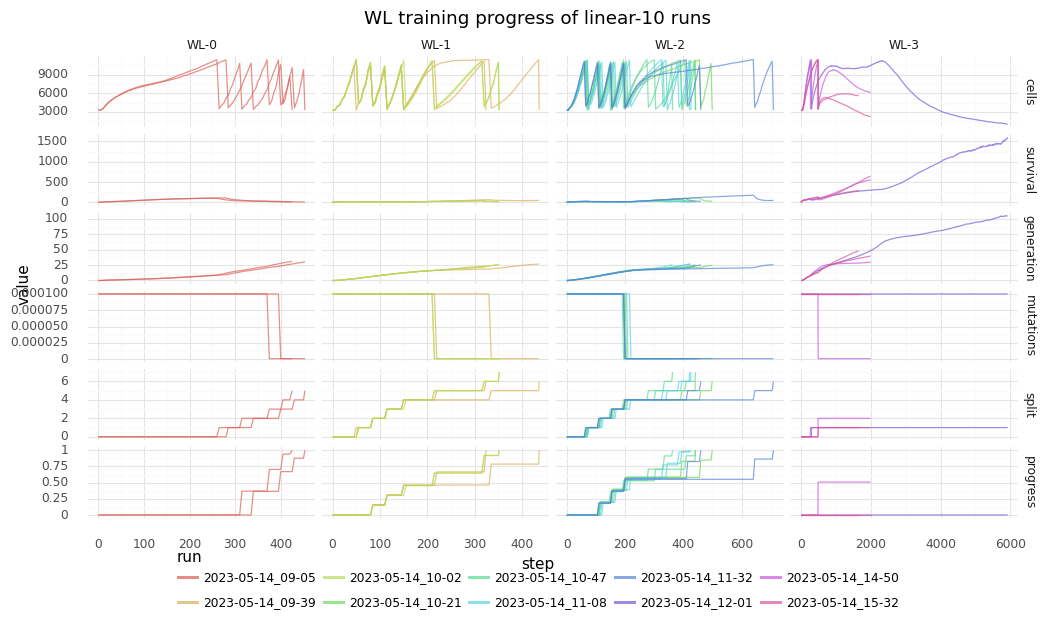

<ggplot: (8729797100490)>

In [5]:
scalars = ["cells", "survival", "generation", "mutations", "split", "progress"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "stage"]], on="name")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ stage", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle(f"WL training progress of {runs_label} runs"))

Most WL-3 runs failed more or less immediately. Only `2023-05-14_14-50` achieved 50% progress.
In the proceeding WL-2 runs it looks like cells struggle a bit after 50% progress.
They make it to 100% but not with a very high growth rate.
I wonder whether this is an indication that something went wrong already in WL-2.
After all, this should be the difficult stage.
On the other hand, in some WL-1 runs, the growth rate is also a bit low towards the end.

In [6]:
world = ms.World.from_file(rundir=SAVED_RUNS_DIR / runs_label, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [7]:
run_names = ["2023-05-14_12-01_0", "2023-05-14_14-50_0", "2023-05-14_15-32_0", "2023-05-14_15-32_1"]
steps = [0, 100, 500]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-14_12-01_0: 3,276 cells at step 0
2023-05-14_12-01_0: 5,147 cells at step 100
2023-05-14_12-01_0: 8,081 cells at step 500
2023-05-14_14-50_0: 3,276 cells at step 0
2023-05-14_14-50_0: 5,378 cells at step 100
2023-05-14_14-50_0: 4,015 cells at step 500
2023-05-14_15-32_0: 3,276 cells at step 0
2023-05-14_15-32_0: 4,512 cells at step 100
2023-05-14_15-32_0: 3,780 cells at step 500
2023-05-14_15-32_1: 3,276 cells at step 0
2023-05-14_15-32_1: 4,708 cells at step 100
2023-05-14_15-32_1: 3,668 cells at step 500


In [8]:
df = proteomes_df.loc[proteomes_df["step"] == 0]
grp = df.groupby("dom")["exists"]
df = (grp.sum() / grp.count()).reset_index()
df[df["exists"] > 0.8]

,dom,exists
15,CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA,0.982601
30,E [trnsp],0.994658
43,HS-CoA + X + X + X + X + X <-> acetyl-CoA,0.992521
49,HS-CoA [trnsp],0.859890
53,NADP + methyl-FH4 <-> NADPH + methylen-FH4,0.865842
54,NADP + methylen-FH4 <-> NADPH + formyl-FH4,0.855693
89,formyl-FH4 [trnsp],0.905983
107,methyl-FH4 [trnsp],0.977793


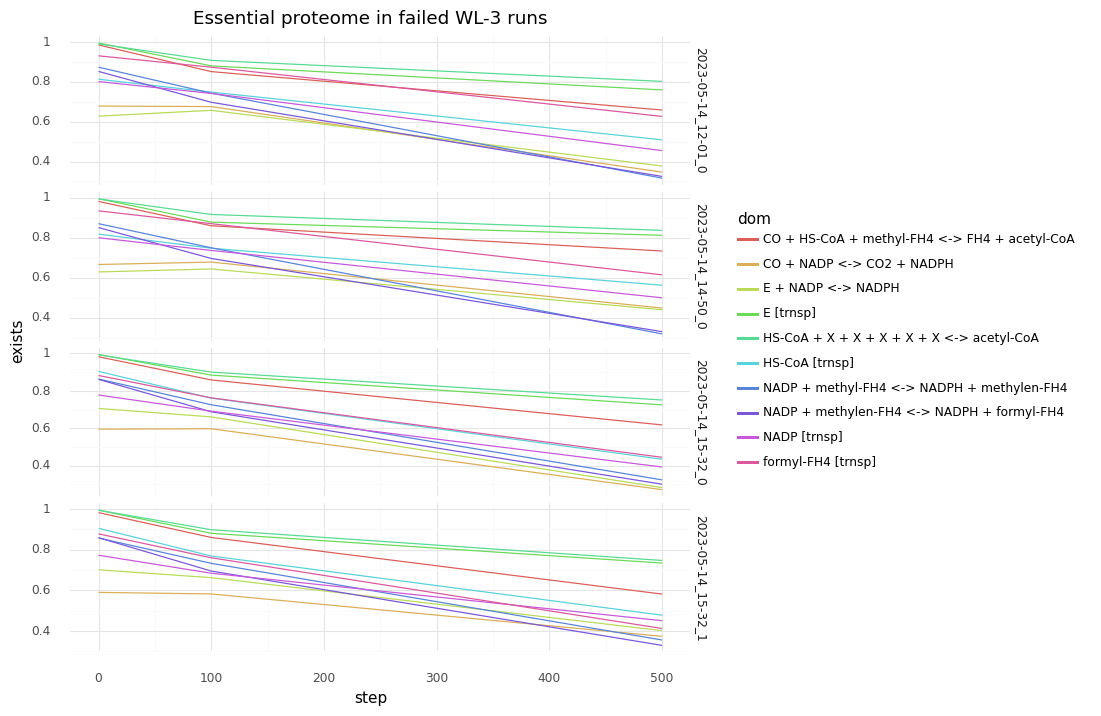

<ggplot: (8729734830582)>

In [11]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'NADP + methylen-FH4 <-> NADPH + formyl-FH4',
    'NADP + methyl-FH4 <-> NADPH + methylen-FH4',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'formyl-FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 8))
    + ggtitle("Essential proteome in failed WL-3 runs"))

Firstly, in WL-3 many cells are missing $\text{CO} + \text{NADP} \rightleftharpoons \text{NADPH} + \text{CO2}$ and $\text{E} + \text{NADP} \rightleftharpoons \text{NADPH}$.
NADPH cannot be regenerated. That means there is no use for the NADP transporter and the 2 newly added catalytic domains, which both require NADPH, will soon run dry. Which means they will quickly also become useless.
This and the lack of CO regeneration will then eventually also let acetyl-CoA regeneration run dry.
So, it makes sense that all these proteins start disappearing once the NADPH regenration disappeared.

$\text{CO} + \text{NADP} \rightleftharpoons \text{NADPH} + \text{CO2}$ and $\text{E} + \text{NADP} \rightleftharpoons \text{NADPH}$ were actually added in WL-2.
It is strange that only 50% to 60% of cells have it at the beginning of WL-3.
So, some cells did pick it up in WL-2 and they were able to grow sufficiently well to still make up >50% after the passage.
But it seems they were not fine-tuned well.
Otherwise, they should have been able to make up >80%.
Some competing cells might have made it through WL-2 without really adapting NADPH regeneration, but with still finding a way to grow enough to make up >40%.

I wonder whether the fine-tuning phase should have been longer in WL-2, and why some cells were able to still grow competitively without restoring NADPH.
My hypothesis is that cells have built up a buffer of other molecules that would then be converted to X once X concentrations got low enough.

## Immediate-10

In earlier runs I saw that cells can start to get rid of newly given genes at the very begining of a stage.
This would happen when the new genes don't immediately give cells an advantage.
When the medium is changed from complex to minimal too slowly, all added genes would have disappeared before cells even need them.
So, it seems to be wise to switch to minimal medium immediately after cells were given new genes.

Here, in each stage, the to-be-removed molecule was immediately removed.
So, cells started growing in minimal medium from the start on.
There was first the adaption phase with high mutation rate, then a final phase with low adaption rate.
Cells had to grow for 10 generation in adaption phase and for 10 generations in final phase.

Cells started from random genomes of size 500 with genes added in inserts of size 200.
Always 2 trials were done for each run.
The final genomes of each successful trial of one stage was used as initial genomes for the next stage.
So, if all trials were successful there would be 2 trials for WL-0, 4 for WL-1, 8 for WL-2.
At WL-2 trials started failing and I aborted to take a look at them.

In [4]:
runs_label = "immediate-10"
scalars = [
    ("Cells/Total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Progress", "progress"),
]

scalars_df = load_scalars(f"{runs_label}/*", scalars)
hparams_df = load_hparams(f"{runs_label}/*")
hparams_df.rename(columns={"pathway_label": "stage", "init_label": "init_genome"}, inplace=True)
hparams_df[["name", "stage", "init_genome"]].sort_values("name")

,name,stage,init_genome
8,2023-05-15_07-11_0,WL-0,random
7,2023-05-15_07-11_1,WL-0,random
4,2023-05-15_07-35_0,WL-1,2023-05-15_07-11_0:-1
2,2023-05-15_07-35_1,WL-1,2023-05-15_07-11_0:-1
6,2023-05-15_08-08_0,WL-1,2023-05-15_07-11_1:-1
3,2023-05-15_08-08_1,WL-1,2023-05-15_07-11_1:-1
1,2023-05-15_08-42_0,WL-2,2023-05-15_07-35_0:-1
0,2023-05-15_08-42_1,WL-2,2023-05-15_07-35_0:-1
5,2023-05-15_10-36_0,WL-2,2023-05-15_07-35_1:-1


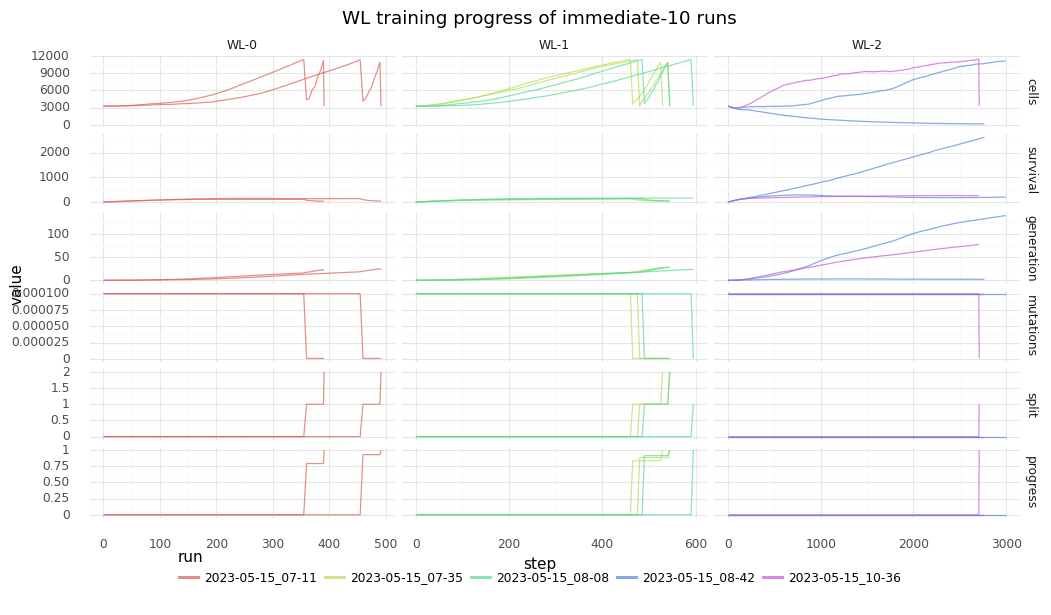

<ggplot: (8740293152615)>

In [5]:
scalars = ["cells", "survival", "generation", "mutations", "split", "progress"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "stage"]], on="name")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ stage", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle(f"WL training progress of {runs_label} runs"))

Run `2023-05-15_10-36_0` eached 100% progress but with a way too low growth rate. I noticed that merely using the number of generations as measure for progress is not sufficient. Here, cells grow and increase their average number of cell divisions. But they do so at a very slow pace. And while one trial even reaches above 100 generations, it didn't even cover the place up once to over 70%. It might make sense to include the average growth rate or a cumulative number of genrations.

In [6]:
world = ms.World.from_file(rundir=SAVED_RUNS_DIR / runs_label, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [8]:
run_names = ["2023-05-15_08-42_0", "2023-05-15_08-42_1", "2023-05-15_10-36_0"]
steps = [0, 500, 1000]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-15_08-42_0: 3,276 cells at step 0
2023-05-15_08-42_0: 3,234 cells at step 500
2023-05-15_08-42_0: 4,214 cells at step 1,000
2023-05-15_08-42_1: 3,276 cells at step 0
2023-05-15_08-42_1: 1,904 cells at step 500
2023-05-15_08-42_1: 1,011 cells at step 1,000
2023-05-15_10-36_0: 3,276 cells at step 0
2023-05-15_10-36_0: 6,140 cells at step 500
2023-05-15_10-36_0: 8,091 cells at step 1,000


In [9]:
df = proteomes_df.loc[proteomes_df["step"] == 0]
grp = df.groupby("dom")["exists"]
df = (grp.sum() / grp.count()).reset_index()
df[df["exists"] > 0.8]

,dom,exists
15,CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA,0.835368
16,CO + NADP <-> CO2 + NADPH,0.869353
28,E + NADP <-> NADPH,0.867013
30,E [trnsp],0.866606
43,HS-CoA + X + X + X + X + X <-> acetyl-CoA,0.893468
58,NADP [trnsp],0.845442
107,methyl-FH4 [trnsp],0.840965


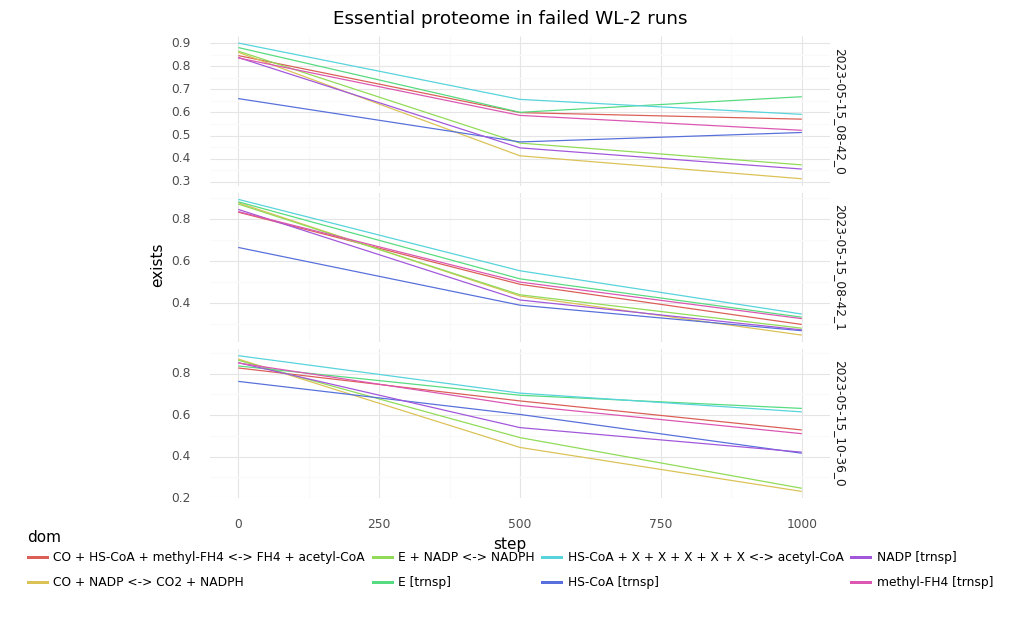

<ggplot: (8740290391893)>

In [10]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'methyl-FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 6), legend_position="bottom")
    + ggtitle("Essential proteome in failed WL-2 runs"))

As in earlier runs, these cells stared loosing their NADPH regenrating capabilities. Once cells run out of NADPH, the NADPH-dependent reactions run dry and the associated genes offer no advantage anymore. One odd thing is that trials `2023-05-15_08-42_0` and `2023-05-15_08-42_1` started out with a less than 80% of cells having a HS-CoA transporter. Both these trials used the resulting genomes of the previous trial `2023-05-15_07-35_0:-1` to initialize their genomes. So, it seems that in `2023-05-15_07-35_0:-1` HS-CoA transporter carrying cells did not yet become dominant.

## Dynamic-10

In earlier runs I saw that cells can start to get rid of newly given genes at the very begining of a stage.
This would happen when the new genes don't immediately give cells an advantage.
When the medium is changed from complex to minimal too slowly, all added genes would have disappeared before cells even need them.
So, it seems to be wise to switch to minimal medium immediately after cells were given new genes.

Next, it seems that concluding a training stage too early would risk cells not being prepared for the next stage.
Cells quickly aquire a buffer of other metabolites that can keep X production up once intracellular X levels are low enough.
So, even without making use of the intended genes to grow in a stage's minimal medium cells can still keep a low growth rate for a while.
Additonally, cells that do follow the intended path first need become the dominant type.
Some cells might incorporate the new genes, but they are not fine-tuned yet and so their growth rate might not exceed the other cells' growth rate yet.
So, it seems prudent to not finish the training until fast growing cells have become dominant.

Here, in each stage, the to-be-removed molecule was immediately removed.
So, cells started growing in minimal medium from the start on.
There was first the adaption phase with high mutation rate, then a final phase with low adaption rate.
For advancing into the next phase cells would have to grow 1 batch with a minimum growth rate of `0.01` (quite conservative).

Cells started from random genomes of size 500 with genes added in inserts of size 200.
Always 2 trials were done for each run.
The final genomes of each successful trial of one stage was used as initial genomes for the next stage.
So, if all trials were successful there would be 2 trials for WL-0, 4 for WL-1, 8 for WL-2.
At WL-2 trials started failing and I aborted to take a look at them.

In [79]:
runs_label = "dynamic-10"
scalars = [
    ("Cells/Total", "cells"),
    ("Cells/Generation", "generation"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Progress", "progress"),
]

scalars_df = load_scalars(f"{runs_label}/*", scalars)
hparams_df = load_hparams(f"{runs_label}/*")
hparams_df.rename(columns={"pathway_label": "stage", "init_label": "init_genome"}, inplace=True)
hparams_df[["name", "stage", "init_genome"]].sort_values("name")

,name,stage,init_genome
3,2023-05-15_12-31_0,WL-0,random
8,2023-05-15_12-31_1,WL-0,random
7,2023-05-15_12-56_0,WL-1,2023-05-15_12-31_0:-1
1,2023-05-15_12-56_1,WL-1,2023-05-15_12-31_0:-1
2,2023-05-15_13-49_0,WL-1,2023-05-15_12-31_1:-1
5,2023-05-15_13-49_1,WL-1,2023-05-15_12-31_1:-1
0,2023-05-15_14-20_0,WL-2,2023-05-15_12-56_0:-1
4,2023-05-15_14-20_1,WL-2,2023-05-15_12-56_0:-1
6,2023-05-15_16-53_0,WL-2,2023-05-15_12-56_1:-1


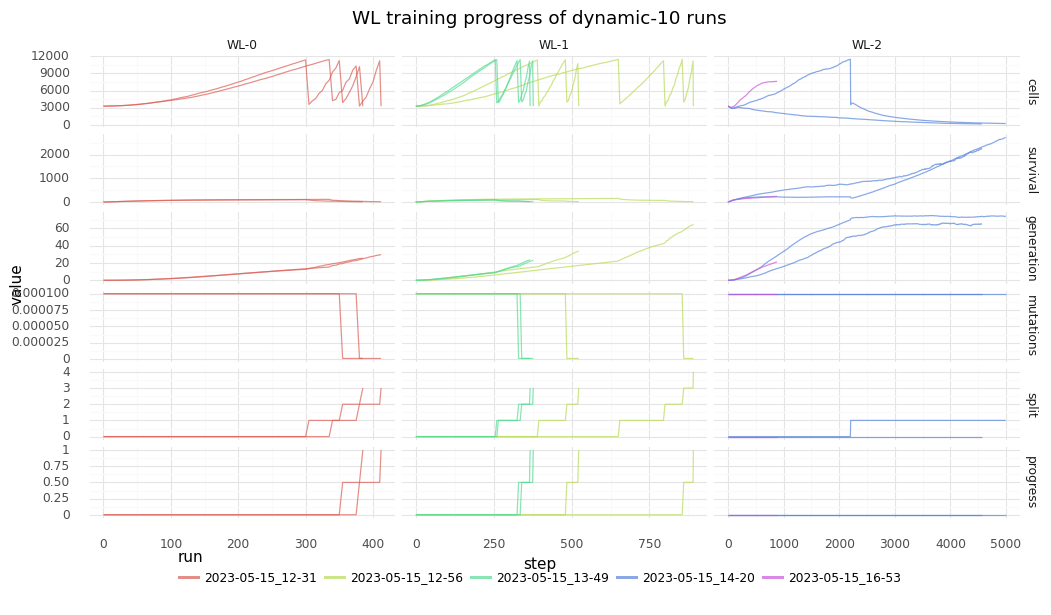

<ggplot: (8735603913602)>

In [4]:
scalars = ["cells", "survival", "generation", "mutations", "split", "progress"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "stage"]], on="name")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ stage", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle(f"WL training progress of {runs_label} runs"))

In the successful trials (of WL-0 and WL-1) the cells were usually struggling a little bit at first with a very slow growth rate.
But this was the intention of the adaption strategy, to only advance into the next phase if they surpassed a certain growth rate.
The idea here was that only if they make use of the highly concentrated substrate, they can continously achieve a high growth rate.
If they had instead created some other pathway that would make use of molecules that exist in the medium only at low concentrations,
they might have been able to advance based on generations, but not with a high enough growth rate.
So, the first runs looked really good to me.
Once they surpassed the growth rate once (where progress increment above 0 the first time) they quickly completed the stage.

Then, in WL-2 `2023-05-15_14-20_0` never really took off. The cells just slowly died (there was a 5000 step limit).
`2023-05-15_14-20_1` looked good at first, but after the first passage the cells also just died off slowly.
(`2023-05-15_16-53_0` was aborted). I wondered how their proteomes looked like, and why `2023-05-15_14-20_1` after the passage would suddenly stop replicating.

In [77]:
world = ms.World.from_file(rundir=SAVED_RUNS_DIR / runs_label, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [8]:
run_names = ["2023-05-15_14-20_0", "2023-05-15_14-20_1"]
steps = [0, 1000, 2000, 3000]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-15_14-20_0: 3,276 cells at step 0
2023-05-15_14-20_0: 1,979 cells at step 1,000
2023-05-15_14-20_0: 1,236 cells at step 2,000
2023-05-15_14-20_0: 624 cells at step 3,000
2023-05-15_14-20_1: 3,276 cells at step 0
2023-05-15_14-20_1: 6,257 cells at step 1,000
2023-05-15_14-20_1: 10,611 cells at step 2,000
2023-05-15_14-20_1: 1,335 cells at step 3,000


In [59]:
df = proteomes_df.loc[proteomes_df["step"] == 0]
grp = df.groupby("dom")["exists"]
df = (grp.sum() / grp.count()).reset_index()
df[df["exists"] > 0.8]

,dom,exists
15,CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA,0.942766
16,CO + NADP <-> CO2 + NADPH,0.864469
28,E + NADP <-> NADPH,0.858669
30,E [trnsp],0.954670
43,HS-CoA + X + X + X + X + X <-> acetyl-CoA,0.957112
49,HS-CoA [trnsp],0.860195
58,NADP [trnsp],0.845849
107,methyl-FH4 [trnsp],0.943376


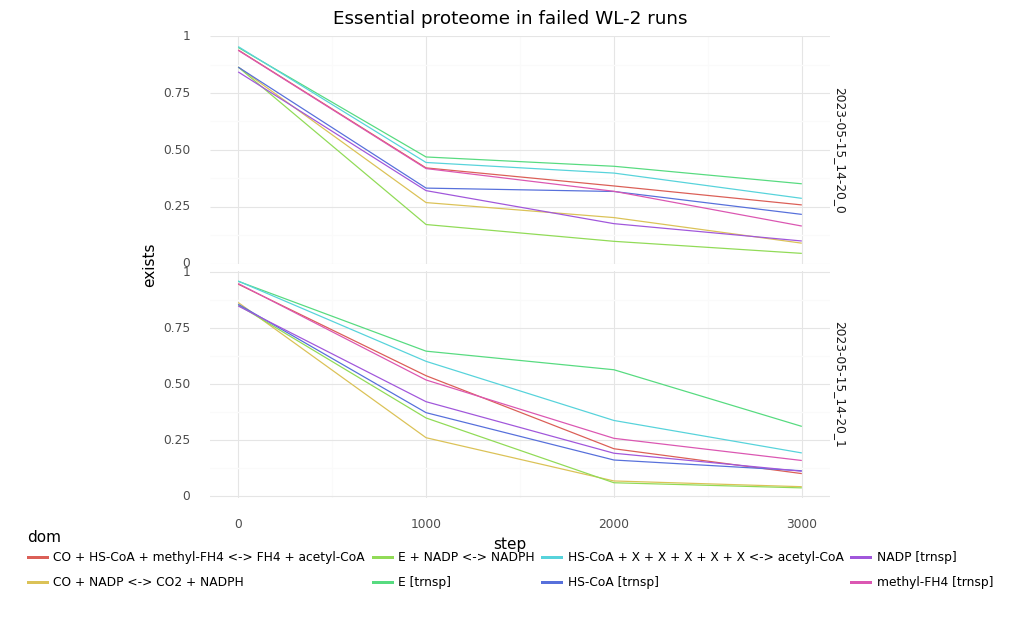

<ggplot: (8778915046217)>

In [53]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'methyl-FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 6), legend_position="bottom")
    + ggtitle("Essential proteome in failed WL-2 runs"))

In colors are the domains that are needed in stage WL-2.
On the y axis is the proportion of cells that have at least one protein with this domain.
At the beginning of both trials, all essential domains exist in more than 80% of cells.
So, the previous stages were indeed successful.
Additionally, it seems that cells get rid of useless proteins quite quickly.
Most of them already dropped the acetyl-CoA transporter that was necessary in WL-0.

Then, it looks like cells got rid all aquired proteins rather quickly.
Run `2023-05-15_14-20_1` retained the E transporter until the first passage.
It might be that this is why this trial looked a bit better at first.
Cells were able to keep death rates low for longer.
I think once they loose either one of $\text{CO2} + \text{NADPH} \rightleftharpoons \text{CO} + \text{NADP}$ or $\text{NADP} + E \rightleftharpoons \text{NADPH}$
they will quickly also loose the other WL proteins.
Since without this upstream part, the downstream proteins are useless in the WL-2 minimal medium.

In [87]:
hparams_df[["name", "run", "stage"]].sort_values("stage")

,name,run,stage
3,2023-05-15_12-31_0,2023-05-15_12-31,WL-0
8,2023-05-15_12-31_1,2023-05-15_12-31,WL-0
1,2023-05-15_12-56_1,2023-05-15_12-56,WL-1
2,2023-05-15_13-49_0,2023-05-15_13-49,WL-1
5,2023-05-15_13-49_1,2023-05-15_13-49,WL-1
7,2023-05-15_12-56_0,2023-05-15_12-56,WL-1
0,2023-05-15_14-20_0,2023-05-15_14-20,WL-2
4,2023-05-15_14-20_1,2023-05-15_14-20,WL-2
6,2023-05-15_16-53_0,2023-05-15_16-53,WL-2


## Dynamic-8

In [11]:
runs_label = "dynamic-8"
scalars = [
    ("Cells/Total", "cells"),
    ("Cells/cPD", "cPD"),
    ("Cells/GrowthRate", "growthRate"),
    ("Cells/Divisions", "divisions"),
    ("Cells/Survival", "survival"),
    ("Other/Split", "split"),
    ("Other/MutationRate", "mutations"),
    ("Other/Progress", "progress"),
]

scalars_df = load_scalars(f"{runs_label}/*", scalars)
hparams_df = load_hparams(f"{runs_label}/*")
hparams_df.rename(columns={"pathway_label": "stage", "init_label": "init_genome"}, inplace=True)
hparams_df[["name", "stage", "init_genome"]].sort_values("name")

,name,stage,init_genome
15,2023-05-23_12-15_0,WL-0,random
21,2023-05-23_12-15_1,WL-0,random
9,2023-05-23_12-15_2,WL-0,random
10,2023-05-23_12-19_0,WL-1,2023-05-23_12-15_1:-1
23,2023-05-23_12-19_1,WL-1,2023-05-23_12-15_1:-1
27,2023-05-23_12-19_2,WL-1,2023-05-23_12-15_1:-1
26,2023-05-23_12-27_0,WL-1,2023-05-23_12-15_2:-1
1,2023-05-23_12-27_1,WL-1,2023-05-23_12-15_2:-1
2,2023-05-23_12-27_2,WL-1,2023-05-23_12-15_2:-1
28,2023-05-23_13-48_0,WL-2,2023-05-23_12-19_0:-1


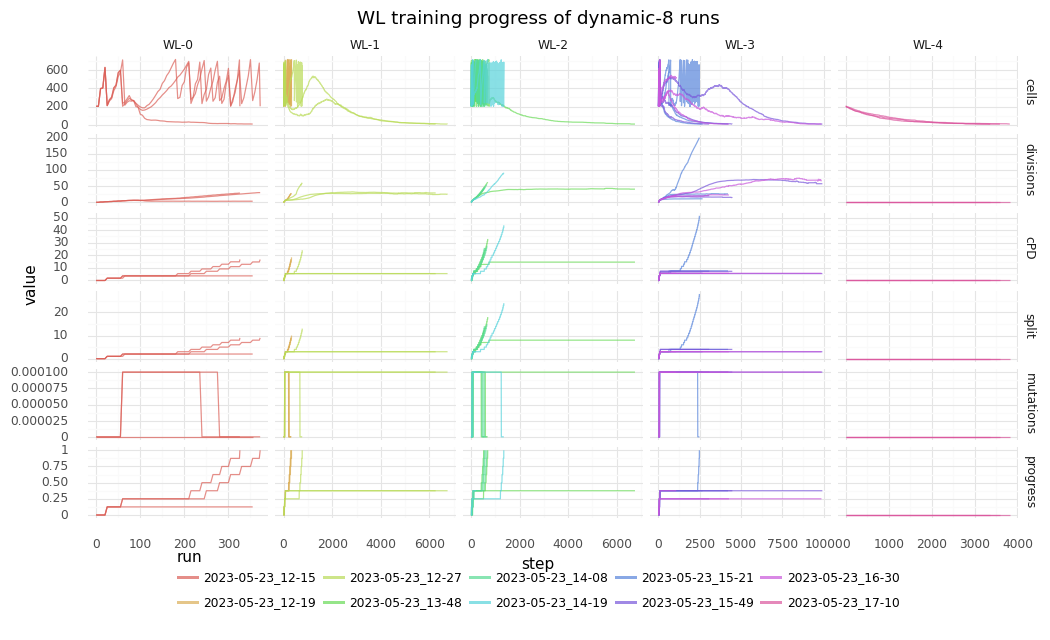

<ggplot: (8764045206408)>

In [4]:
scalars = ["cells", "divisions", "cPD", "split", "mutations", "progress"]
df = scalars_df[scalars_df["scalar"].isin(scalars)].copy()
df["scalar"] = pd.Categorical(df["scalar"], categories=scalars, ordered=True)
df = df.merge(hparams_df[["run", "trial", "name", "stage"]], on="name")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="run"), alpha=0.7)
    + facet_grid("scalar ~ stage", scales="free")
    + theme(figure_size=(12, 6), legend_position="bottom")
    + ggtitle(f"WL training progress of {runs_label} runs"))

In [4]:
world = ms.World.from_file(rundir=SAVED_RUNS_DIR / runs_label, device="cpu")
mol_2_idx = {d.name: i for i, d in enumerate(world.chemistry.molecules)}

In [6]:
run_names = ["2023-05-23_17-10_0", "2023-05-23_17-10_1", "2023-05-23_17-10_2"]
steps = [0, 1000]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-23_17-10_0: 204 cells at step 0
2023-05-23_17-10_0: 63 cells at step 1,000
2023-05-23_17-10_1: 204 cells at step 0
2023-05-23_17-10_1: 87 cells at step 1,000
2023-05-23_17-10_2: 204 cells at step 0
2023-05-23_17-10_2: 74 cells at step 1,000


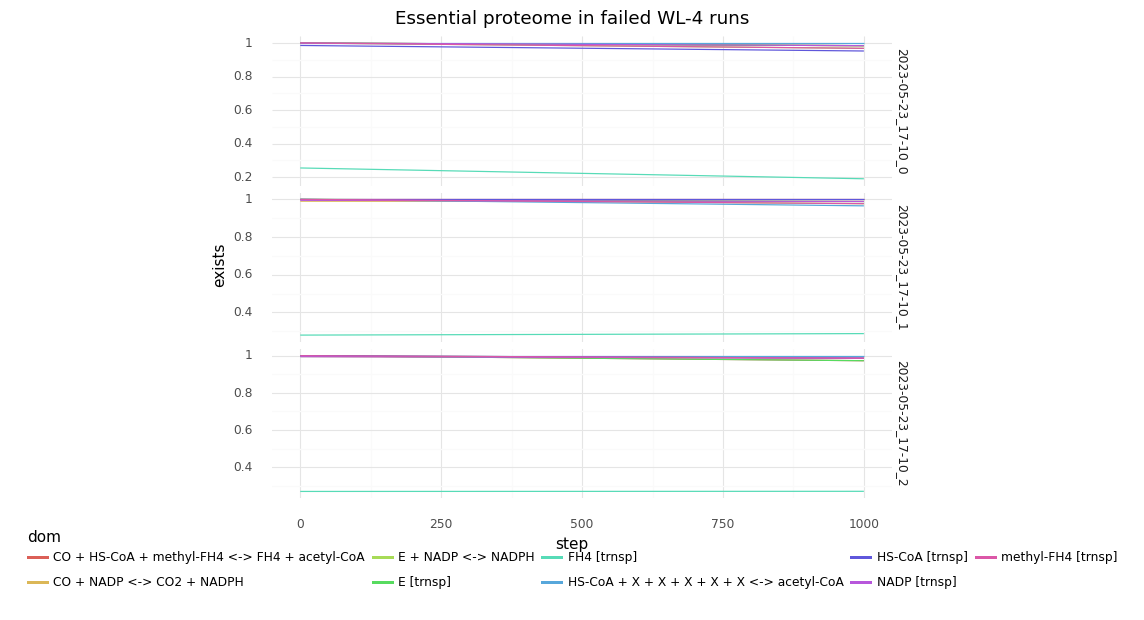

<ggplot: (8764119663914)>

In [9]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'methyl-FH4 [trnsp]',
    'FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 6), legend_position="bottom")
    + ggtitle("Essential proteome in failed WL-4 runs"))

In [8]:
run_names = ["2023-05-23_15-21_0", "2023-05-23_15-21_1", "2023-05-23_15-21_2"]
steps = [0, 500, 1000, 1500, 2000]
proteomes_df = get_existing_domains(world=world, runs_label=runs_label, run_names=run_names, steps=steps)

2023-05-23_15-21_0: 204 cells at step 0
2023-05-23_15-21_0: 106 cells at step 500
2023-05-23_15-21_0: 47 cells at step 1,000
2023-05-23_15-21_0: 25 cells at step 1,500
2023-05-23_15-21_0: 15 cells at step 2,000
2023-05-23_15-21_1: 204 cells at step 0
2023-05-23_15-21_1: 597 cells at step 500
2023-05-23_15-21_1: 138 cells at step 1,000
2023-05-23_15-21_1: 73 cells at step 1,500
2023-05-23_15-21_1: 41 cells at step 2,000
2023-05-23_15-21_2: 204 cells at step 0
2023-05-23_15-21_2: 467 cells at step 500
2023-05-23_15-21_2: 218 cells at step 1,000
2023-05-23_15-21_2: 641 cells at step 1,500
2023-05-23_15-21_2: 376 cells at step 2,000


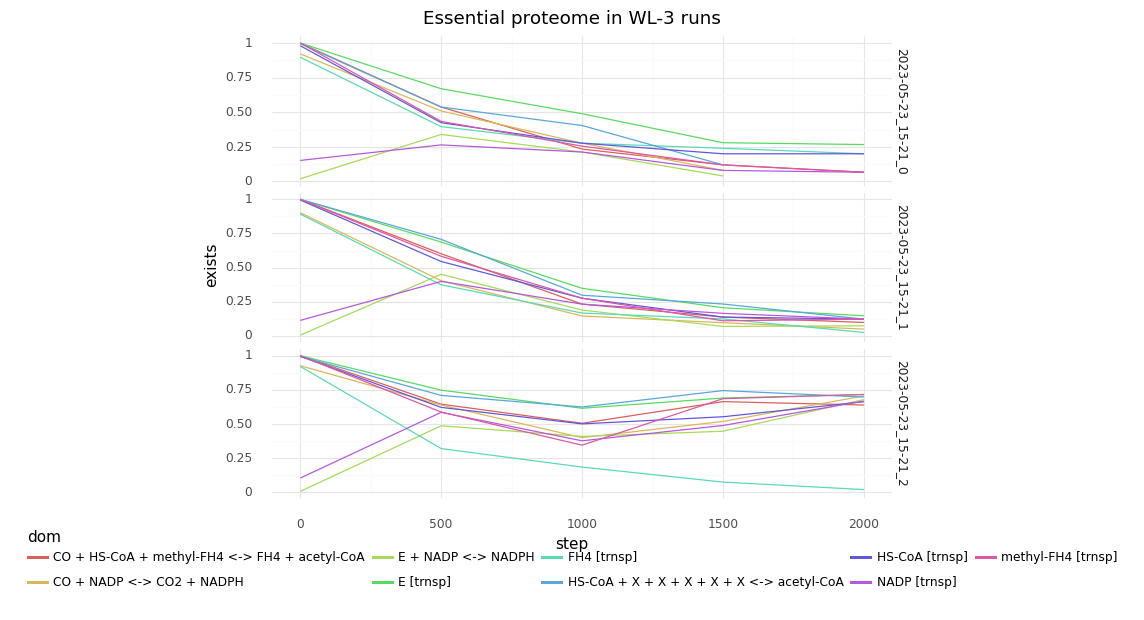

<ggplot: (8754580137666)>

In [9]:
req_doms = [
    'E + NADP <-> NADPH',
    'CO + NADP <-> CO2 + NADPH',
    'CO + HS-CoA + methyl-FH4 <-> FH4 + acetyl-CoA',
    'HS-CoA + X + X + X + X + X <-> acetyl-CoA',
    'E [trnsp]',
    'NADP [trnsp]',
    'HS-CoA [trnsp]',
    'methyl-FH4 [trnsp]',
    'FH4 [trnsp]'
]

df = proteomes_df[proteomes_df["dom"].isin(req_doms)]
grp = df.groupby(["run", "step", "dom"])["exists"]
df = (grp.sum() / grp.count()).reset_index()

(ggplot(df)
    + geom_line(aes(y="exists", x="step", color="dom"))
    + facet_grid("run ~ .", scales="free")
    + theme(figure_size=(8, 6), legend_position="bottom")
    + ggtitle("Essential proteome in WL-3 runs"))

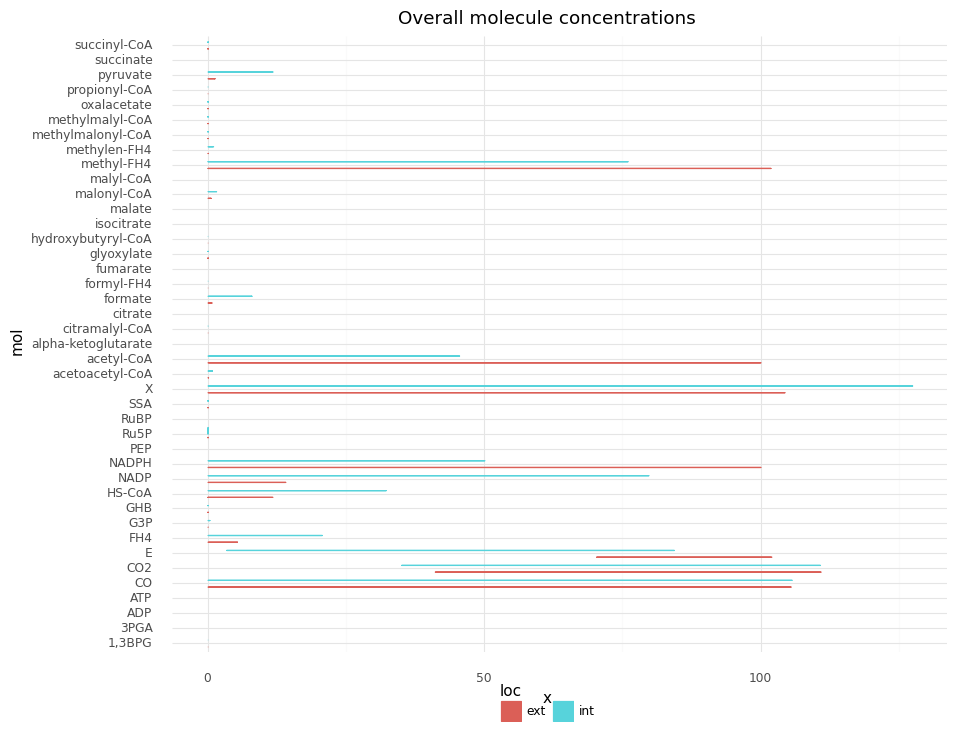

<ggplot: (8754575320857)>

In [15]:
molecules_df = get_molecules_df(world=world, runs_label=runs_label, run_names=hparams_df["name"].tolist())
molecules_df = molecules_df.merge(hparams_df[["name", "stage"]], on="name")

(ggplot(molecules_df)
    + geom_violin(aes(y="x", x="mol", color="loc", fill="loc"), position="dodge")
    + coord_flip()
    + theme(figure_size=(10, 8), legend_position="bottom")
    + ggtitle("Overall molecule concentrations"))

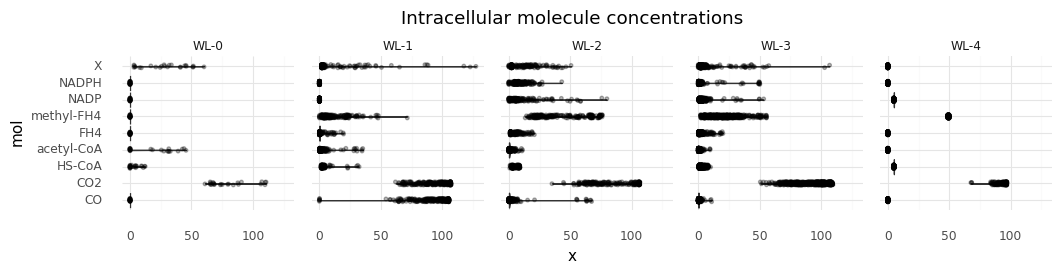

<ggplot: (8754553940137)>

In [16]:
molecules = [
    "CO", "CO2",
    "HS-CoA", "acetyl-CoA", 
    "FH4", "methyl-FH4",
    "NADP", "NADPH",
    "X"
]
loc_mask = molecules_df["loc"] == "int"
mol_mask = molecules_df["mol"].isin(d for d in molecules)
df = molecules_df[loc_mask & mol_mask].copy()
df["mol"] = pd.Categorical(df["mol"], categories=molecules)

(ggplot(df)
    + geom_violin(aes(x="mol", y="x"))
    + geom_jitter(aes(x="mol", y="x"), size=1, alpha=0.3, width=0.1, height=0.1)
    + facet_grid(". ~ stage", scales="free")
    + coord_flip()
    + theme(figure_size=(12, 2), legend_position="bottom", subplots_adjust={'wspace': 0.1})
    + ggtitle("Intracellular molecule concentrations"))